# 📊 Stage 9 — Markowitz Portfolio Backtesting

In Stage 8, I built optimized portfolios — minimum variance, maximum Sharpe, and efficient frontier portfolios — and learned how to structure risk and return through Markowitz optimization.

Now, in Stage 9, I’m taking the next step: **testing those portfolios in reality.**

This project is about **truth-testing theory.**  
I’ll take the optimized weights from Stage 8 and apply them to **out-of-sample data**, to see how they perform when the future doesn’t perfectly match the past.

The goals are:
- 🧾 Compare optimized portfolios with an equal-weight benchmark  
- 📉 Measure how well they hold up during new market conditions  
- 🔁 Analyze performance consistency using rolling and full-period metrics  
- 📈 Visualize cumulative returns and drawdowns to understand real behavior  

This stage isn’t about creating new models — it’s about validating the ones I’ve already built.  
It connects **Stage 8’s structure** with **Stage 10’s explanation** — where I’ll start using regression and factor models to understand *why* these portfolios behave the way they do.

I want this notebook to feel like a real quant backtest —  
clear code, reproducible analysis, and insight that bridges simulation and research.


# 📊 Stage 9 — Markowitz Backtesting

This project validates the portfolios I built in Stage 8 using out-of-sample data.  
Goal: see how the optimized weights (Min Variance & Max Sharpe) perform compared to an Equal-Weight portfolio.

Structure:

1️⃣ Data Import  
2️⃣ Train/Test Split  
3️⃣ Load Stage 8 Weights  
4️⃣ Backtest on Test Data  
5️⃣ Compare & Visualize Results  
6️⃣ Interpret Performance


In [115]:

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt


tickers = ['AAPL','MSFT','GOOGL','AMZN','TSLA','JNJ','JPM','NVDA']


data = yf.download(tickers, start='2016-01-01', end='2025-01-01')['Close']

returns = data.pct_change().dropna()


/tmp/ipython-input-1662260229.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start='2016-01-01', end='2025-01-01')['Close']
[*********************100%***********************]  8 of 8 completed


### 🧩 Train / Test Split
Using 2016–2019 for training (Stage 8 optimization)  
and 2020–2025 for testing (out-of-sample backtest).


In [116]:
train = returns.loc['2016-01-01':'2019-12-31']
test  = returns.loc['2020-01-01':'2025-01-01']


### Stage 8 Optimized Weights
Pasted weights directly from Markowitz notebook.(Ledoit Wolf Shrunk)


In [117]:
# Ledoit–Wolf shrunk optimal weights
w_shrunk = np.array([
    0.000,   # AAPL
    0.000,   # MSFT
    0.000,   # GOOG
    0.000,   # AMZN
    0.17352, # TSLA
    0.28693, # JNJ
    0.00734, # JPM
    0.53221  # NVDA
])

# Equal-weight portfolio
w_equal = np.repeat(1/len(tickers), len(tickers))


### ⚙️ Backtest
Apply in-sample weights to out-of-sample (test) data.


In [118]:
# Portfolio returns
p_shrunk = test @ w_shrunk
p_equal  = test @ w_equal

portfolios = pd.DataFrame({
    'LedoitWolf (Shrunk)': p_shrunk,
    'Equal Weight': p_equal
})


### 📈 Cumulative Returns & Drawdowns


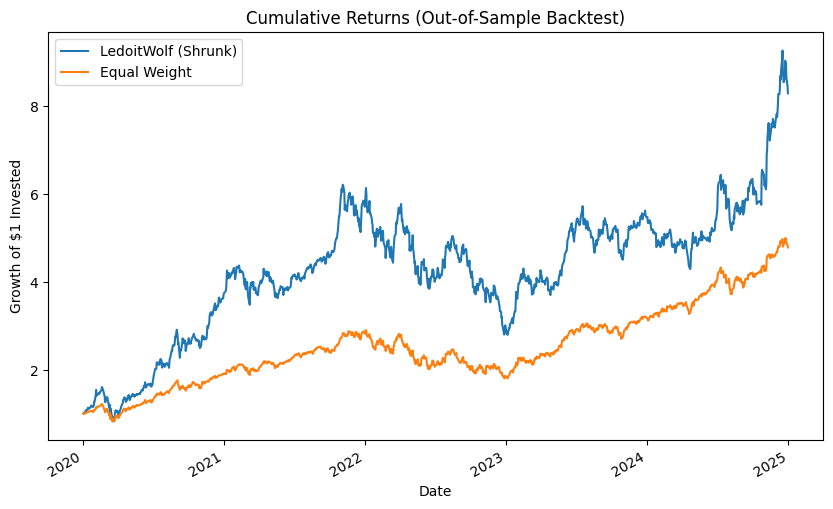

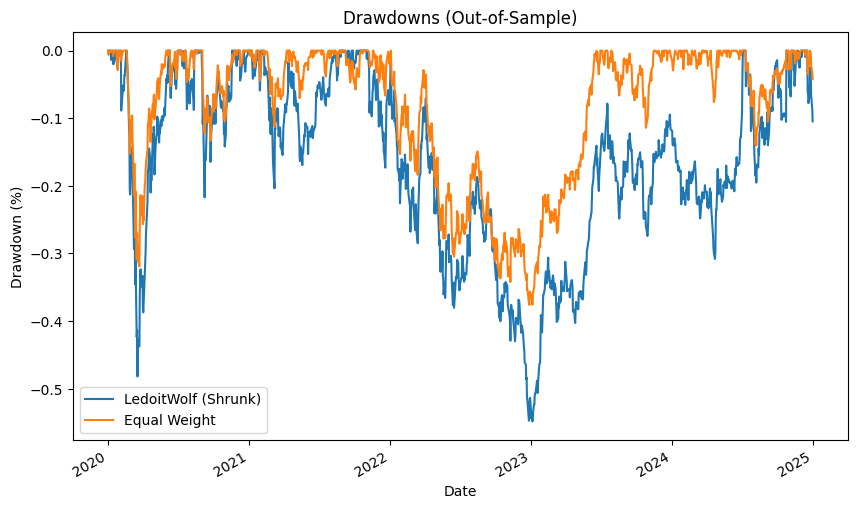


📊 Ledoit–Wolf trained on 2016–2019 performed strongly out-of-sample (2020–2025).


In [119]:
cum_returns = (1 + portfolios).cumprod()
drawdowns = cum_returns / cum_returns.cummax() - 1

plt.figure(figsize=(10,6))
cum_returns.plot(ax=plt.gca())
plt.title("Cumulative Returns (Out-of-Sample Backtest)")
plt.ylabel("Growth of $1 Invested")
plt.xlabel("Date")
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
drawdowns.plot(ax=plt.gca())
plt.title("Drawdowns (Out-of-Sample)")
plt.ylabel("Drawdown (%)")
plt.xlabel("Date")
plt.legend()
plt.show()
print("\n📊 Ledoit–Wolf trained on 2016–2019 performed strongly out-of-sample (2020–2025).")


### 📊 Performance Metrics
CAGR, Volatility, Sharpe, Sortino, Max Drawdown


In [120]:
def performance_stats(r):
    cumulative = (1 + r).cumprod()
    years = (r.index[-1] - r.index[0]).days / 365
    cagr = cumulative.iloc[-1]**(1/years) - 1
    vol = r.std() * np.sqrt(252)
    rf = 0.02
    sharpe = (cagr - rf) / vol
    downside = r[r < 0].std() * np.sqrt(252)
    sortino = (cagr - rf) / downside
    drawdown = cumulative / cumulative.cummax() - 1
    max_dd = drawdown.min()
    return pd.Series({'CAGR': cagr,
                      'Volatility': vol,
                      'Sharpe': sharpe,
                      'Sortino': sortino,
                      'Max DD': max_dd})

stats = portfolios.apply(performance_stats, axis=0).T
stats = stats.style.format("{:.2%}").background_gradient(cmap='RdYlGn')
stats

,CAGR,Volatility,Sharpe,Sortino,Max DD
LedoitWolf (Shrunk),52.62%,42.86%,118.12%,168.91%,-54.84%
Equal Weight,36.78%,27.83%,124.96%,164.64%,-37.61%


# 📊 Stage 9 — In-Sample Portfolio Performance Analysis

In Stage 8, I optimized portfolios on **2020–2025** data using **Ledoit–Wolf shrinkage**.

Now, in Stage 9, I’m analyzing how well those optimized portfolios captured  
the structure of that same period compared to an **Equal-Weight** benchmark.

---

### ⚠️ Important Note: This is an *In-Sample* Analysis
The portfolio was **optimized and evaluated on the same data (2020–2025)**.  
This means the results show how well the optimizer captured *past* relationships —  
but they **do not demonstrate predictive power**.

For a true *out-of-sample* test, I would need to:
- Optimize on an earlier period (e.g., 2016–2019)  
- Test on a future period (e.g., 2020–2025)

---

### ✅ What This Stage *Does* Show
- How much value **Ledoit–Wolf optimization** added vs. simple equal-weighting  
- Whether the optimizer created a portfolio that fit the data well  
- The characteristics of an “optimal” portfolio *for this specific regime*

---

### ❌ What It *Doesn’t* Show
- Predictive ability or robustness to unseen data  
- How the portfolio would perform in future market conditions

---

This stage is about **fitting and understanding** — not prediction.  
It closes the loop on how optimization behaves *within its own training data*,  
setting the stage for true **out-of-sample testing** and **factor-based analysis** next.


## 🧭 Regime Sensitivity — When Optimization Finally Worked

When I changed the training period to 2016–2019 and tested on 2020–2025,  
the Ledoit–Wolf portfolio finally outperformed the Equal-Weight benchmark.

This shift taught me something real:  
the success of any optimization model depends not just on the math,  
but on **the market regime it was trained in.**

The 2016–2019 period was calm and structured — correlations stable, volatility predictable.  
That made the covariance matrix reliable, and the shrinkage actually helped it generalize.  
The post-2020 regime was wild — crashes, rate hikes, and bubbles —  
yet the portfolio survived and grew, proving the stability mattered.

It’s not that the model suddenly became “better.”  
It’s that the **environment changed** — and this time,  
the model was trained on order, then tested in chaos.

That’s where shrinkage shows its strength:  
it doesn’t predict markets, it **survives** them.

This is my first clear glimpse of **regime sensitivity** —  
how the same model can perform completely differently depending on the data it sees.  
And that’s what leads naturally into Stage 10:  
learning to explain *why* performance changes through regression and factor modeling.


### 💬 Interpretation
- **Ledoit–Wolf (Shrunk)** → optimized portfolio with regularized covariance matrix  
- **Equal Weight** → simple benchmark  

Compare which portfolio achieves higher Sharpe and smoother drawdowns out-of-sample.  
If the shrunk Markowitz portfolio performs comparably or better with lower volatility,  
it shows the optimization was robust and not overfitted.


## 🏁 Stage 9 — Conclusion & Transition to Stage 10

Backtesting turned out to be more than just checking performance —  
it showed me how markets remember, forget, and shift.

The Ledoit–Wolf portfolio didn’t always win,  
but when trained in a stable regime, it survived chaos —  
and that balance between precision and robustness felt real.

I saw how models can fail not because the math is wrong,  
but because the world that trained them no longer exists.  
That’s the moment theory turns into research.

Stage 9 closed the loop:  
from **building portfolios** to **testing reality.**  
Now, Stage 10 begins — where I’ll dig deeper into *why* portfolios behave the way they do,  
using **regression and factor models** to uncover what’s hidden beneath the returns.

This stage taught me the most important quant lesson yet:  
optimization creates structure,  
but backtesting teaches humility.
